In [6]:
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (6,6)
import matplotlib.pyplot as plt
import numpy as np
from distgen import Generator
from distgen.physical_constants import unit_registry
from astra.astra_distgen import evaluate_astra_with_distgen
from pmd_beamphysics.plot import marginal_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading in Distgen Inputs

In [7]:
VCC_IN = "files/2019_11_04_135614reg_outreg_laser_in.yaml"
VCC_FILTERED_IN = "files/2019_11_04_135614_filt_outfilt_laser_in.yaml"
SUPERG_IN = "files/2019_11_04_135614.yaml"
RMAX_IN = "files/135614-trunc-rmax.yaml"
CIRC = "files/135614_circ.yaml"
DIST_INPUTS = [VCC_IN, VCC_FILTERED_IN, SUPERG_IN, RMAX_IN, CIRC]

In [8]:
def returnImportantStuff(input_file, bins = 100):
    gen = Generator(input_file)
    gen.input['n_particle'] = 1000000
    gen.run()
    particles = gen.particles
    px = particles['x']
    py = particles['y']
    sig_x = particles['sigma_x']
    sig_y = particles['sigma_y']
    xhist = np.histogram(px, bins = bins)
    yhist = np.histogram(py, bins = bins)
    H, xedges, yedges = np.histogram2d(px, py, bins=bins)
    return particles, xhist, yhist, H

## View the Distgen Inputs

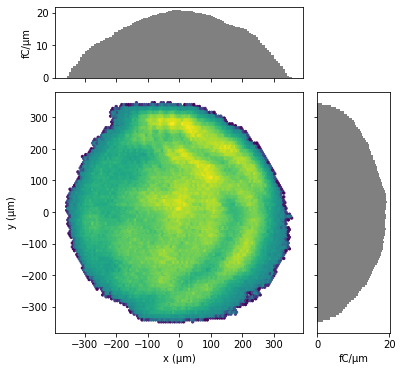

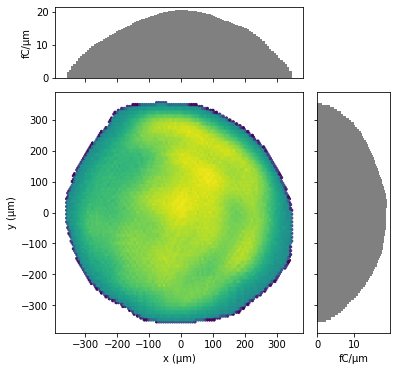

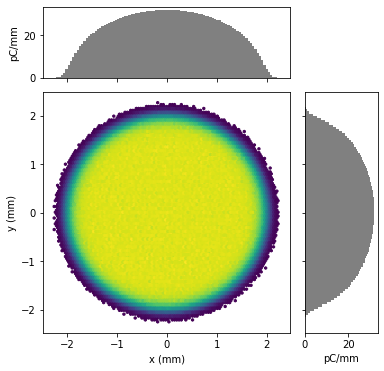

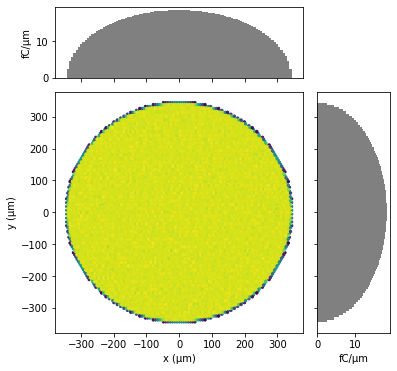

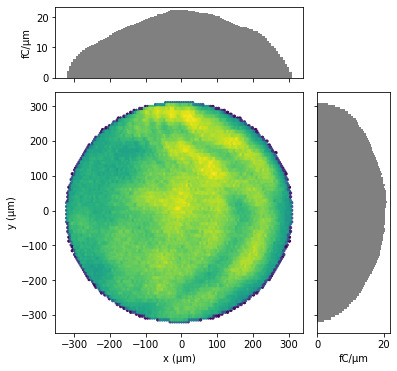

In [9]:
for inp in DIST_INPUTS:
    particles, hx, hy, H= returnImportantStuff(inp, bins = 100)
    marginal_plot(particles, 'x', 'y', bins = 100)
    plt.show()

## Run Astra

Change Astra input and archive directories as needed.

In [10]:
ASTRA_IN = "/global/homes/l/lgupta/cori/GitHub/lcls-lattice/astra/models/gunb_eic/astra.in"
ARCHIVE_PATH = "/global/u1/l/lgupta/m669/datasets/temp"

In [35]:
settings = {}
settings["High Charge = 250pC"] = {"distgen:n_particle": 10000, "lspch": True, "zstop": 1.49, "phi(1)": 0 , "maxb(2)": 0.07 , 
             "distgen:total_charge:value": 250.0 , "zphase": 20}
settings["Low Charge = 25pC"] = {"distgen:n_particle": 10000, "lspch": True, "zstop": 1.49, "phi(1)": 0 , "maxb(2)": 0.07 , 
             "distgen:total_charge:value": 25.0 , "zphase": 20}

NAMES = ["VCC", "VCC_FILTERED", "SUPERG", "RMAX", "CIRC"]

charges = ["High Charge = 250pC", "Low Charge = 25pC"]

outputs = {}
for charge in charges:
    settings0 = settings[charge]
    #print(settings0["distgen:total_charge:value"])
    all_outputs = {}
    for i, inp in enumerate(DIST_INPUTS):
        A = evaluate_astra_with_distgen(settings0, astra_input_file=ASTRA_IN,
                    distgen_input_file=inp, verbose= False , archive_path = ARCHIVE_PATH)
        all_outputs[NAMES[i]] = A
    outputs[charge] = all_outputs
    
print("Done")

250.0
25.0
Done


## View the Results

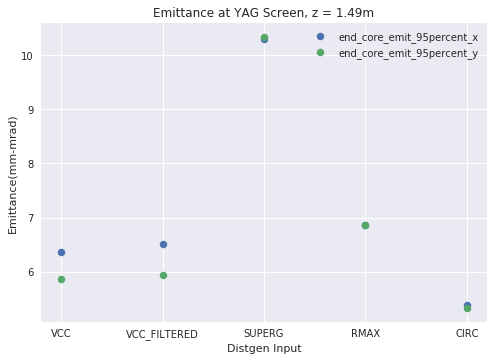

In [12]:
emits = ["end_core_emit_95percent_x", "end_core_emit_95percent_y"]


for charge in charges:
    for e in emits:
        em = []
        for name in NAMES:
            em.append(outputs[charge][name][e])
        mpl.style.use('seaborn')
        plt.title(e)
        plt.plot(NAMES, np.array(em)*1E6, '.', label = e, markersize = 15)
        plt.legend()
    plt.xlabel("Distgen Input")
    plt.ylabel("Emittance(mm-mrad)")
    plt.title(charge + ", Emittance at YAG Screen, z = 1.49m")
    plt.show()

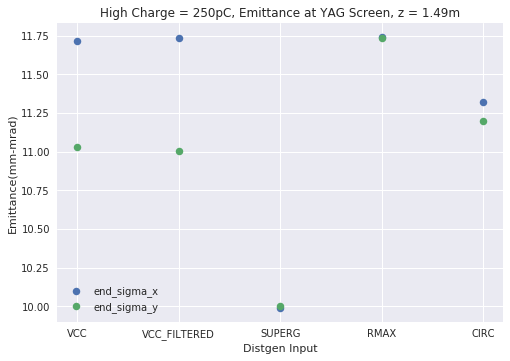

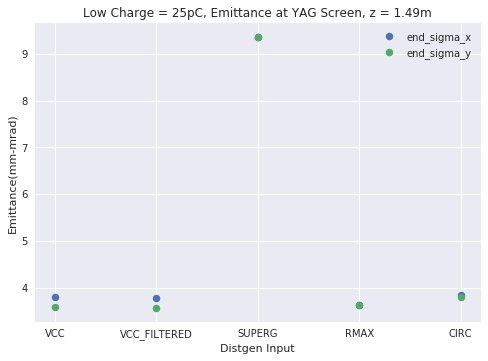

In [39]:
sizes = ['end_sigma_x', 'end_sigma_y']

for charge in charges:
    for e in sizes:
        em = []
        for name in NAMES:
            em.append(outputs[charge][name][e])
        mpl.style.use('seaborn')
        plt.title(e)
        plt.plot(NAMES, np.array(em)*1E3, '.', label = e, markersize = 15)
        plt.legend()
    plt.xlabel("Distgen Input")
    plt.ylabel("Beam Size(mm)")
    plt.title(charge + ", Beam Sizes at YAG Screen, z = 1.49m")
    plt.show()